# validation & prediction with implicit
This notebook contains a grid search for validation with implicit. It also contains a prediction script to produce submissions.

## autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## dir setup

In [2]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

## imports

In [4]:
import numpy as np
from datetime import datetime

import pandas as pd
# pd.set_option('max_rows', None)
# pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

from tqdm import tqdm
tqdm.pandas()

import scipy.sparse as sparse
import implicit

from sklearn.metrics import ndcg_score
from sklearn.model_selection import ParameterGrid

import mlflow

import pickle

/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [63]:
import tensorflow as tf

## project imports

In [5]:
import sys
sys.path.insert(0, '..')

from src.features import *
from src.models import *

# validation

In [6]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'

# validation = 0.2 # 0.2: 20% of original train will be test
# keep_train = 0.6  # 0.6: 60% of train for validation

validation = 0.2 
keep_train = 0.1  

# validation = 0.2 
# keep_train = 0.4 
lang = 'pt'

train, test = read_processed(train_fn, test_fn, keep_train = keep_train, validation = validation, lang = lang)

initial train shape: (12412329, 9)
train/test shapes: (996908, 9) (238695, 8)
lang pt


In [7]:
true_fn = 'true.pkl'
true_fp = os.path.join(processed_data_dir, true_fn)
true_df = pd.read_pickle(true_fp)

item_domain_fn = 'item_domain.pkl'
item_domain_fp = os.path.join(processed_data_dir, item_domain_fn)
item_domain = pd.read_pickle(item_domain_fp)
item_domain['lang_category'] = item_domain.category_id.str[:3].replace({'MLM': 'es', 'MLB': 'pt'})
item_domain = item_domain[item_domain.lang_category == lang]
item_domain.drop('lang_category', axis = 1, inplace = True)

In [44]:
# grid = dict(buy_weight = [200],
#             regularization = [0.01],
#             iterations = [15],
#             factors = [768],
#             alpha_val = [200])

# grid = dict(buy_weight = [400],
#             regularization = [0.001, 0.01, 0.03],
#             iterations = [10, 20, 30],
#             factors = [768],
#             alpha_val = [400])

# grid = dict(buy_weight = [400, 600],
#             extra_weight = [50, 100],
#             regularization = [0.01],
#             iterations = [15],
#             factors = [512],
#             alpha_val = [600])

# grid = dict(buy_weight = [400],
#             extra_weight = [200],
#             regularization = [0.01],
#             iterations = [15],
#             factors = [512, 768, 1024],
#             alpha_val = [400])

grid = dict(buy_weight = [200],
            extra_weight = [200],
            regularization = [0.01],
            iterations = [15],
            factors = [64],
            alpha_val = [100])

grid

{'buy_weight': [200],
 'extra_weight': [200],
 'regularization': [0.01],
 'iterations': [15],
 'factors': [64],
 'alpha_val': [100]}

In [11]:
train

,seq,item_bought,event_info,event_timestamp,event_type,time_diff,lang_seq,in_nav,in_nav_pred
8,104308,678444,CACAROLA FRITADEIRA ESMALTADA CESTO P FRITURA N,2019-10-05 21:58:12,search,NaN,pt,False,0.000000
9,104308,678444,NaN,NaT,buy,NaN,pt,False,0.000000
14,197630,31927,971179,2019-10-05 20:50:03,view,NaN,pt,False,0.127035
15,197630,31927,NaN,NaT,buy,NaN,pt,False,0.127035
28,175189,923286,MAQUINA CORTAR CABELO 10 1 BARBA CORPO,2019-10-13 06:50:14,search,NaN,pt,False,0.000000
...,...,...,...,...,...,...,...,...,...
12409884,53180,1879078,CAMISETA TOMMY HILFIGER,2019-10-27 16:42:18,search,8.0,pt,True,0.456262
12409885,53180,1879078,CAMISETA TOMMY HILFIGER,2019-10-27 16:43:35,search,77.0,pt,True,0.456262
12409886,53180,1879078,CAMISETA TOMMY HILFIGER,2019-10-27 16:43:41,search,6.0,pt,True,0.456262
12409887,53180,1879078,CAMISETA TOMMY HILFIGER,2019-10-27 17:40:22,search,3401.0,pt,True,0.456262


In [46]:
mlflow.set_experiment('no test')

for param in ParameterGrid(grid):
    print(param)
    with mlflow.start_run() as run:
        print("MLflow:")
        print("  run_id:",run.info.run_id)
        print("  experiment_id:",run.info.experiment_id)
        
        test_offset, test_shifted_seq_vals, train_test = join_prepare_train_test(train, test, **param)
        model, seq_map, event_info_map, sparse_user_item = fit_implicit_model(train_test, test_offset, **param)
        pred = predict_implicit_model(model, sparse_user_item, 
                                      seq_map, event_info_map, test_shifted_seq_vals, 
                                      10, test_offset, recalculate_user = True,
                                      validation = True, true_df = true_df, item_domain = item_domain)
        mlflow.log_param('val_keep', {'v': validation, 'k': keep_train})
        mlflow.log_param('lang', lang)
        mlflow.log_param('exp_decay_alpha', 0.03)
        
        pred_fn = 'pred__' + '__'.join([k + '_' + str(v) for k, v in param.items()]) + '.csv'
        pred_fp = os.path.join(cv_dir, pred_fn)
        pred.to_csv(pred_fp)
        
        mlflow.log_params(param)
        # mlflow.log_artifact(pred_fp)
        
        mean_ndcg = pred.ndcg.mean()
        ndcg_larger_than_zero = (pred.ndcg > 0).mean()
        
        print('mean ndcg:', mean_ndcg)
        print('ndcg > 0:', ndcg_larger_than_zero)
        
        mlflow.log_metric('mean_ndcg', mean_ndcg)
        mlflow.log_metric('ndcg_gt_0', ndcg_larger_than_zero)


{'alpha_val': 100, 'buy_weight': 200, 'extra_weight': 200, 'factors': 64, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: 372da690d2704ae989666eba0b36425b
  experiment_id: 6


  0%|          | 3/6605 [00:00<04:13, 26.00it/s]

100%|██████████| 6605/6605 [03:27<00:00, 31.82it/s]


mean ndcg: 0.3313472956034694
ndcg > 0: 0.39530658591975776


In [36]:
sparse_user_item.shape

(35332, 210788)

In [41]:
train_test.seq.unique().shape

(35332,)

_____

# a prediction

In [6]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'

lang = 'pt'

train, test = read_processed(train_fn, test_fn, lang = lang, keep_train = 0.1, validation = 0.2)

initial train shape: (12412329, 9)
train/test shapes: (999762, 9) (242477, 8)
lang pt


In [7]:
# runs = pd.read_csv('/home/jupyter/MercadoLibre_2020/runs.csv')
# param = runs.sort_values('mean_ndcg', ascending = False).loc[3].to_dict()
param = dict()
param['factors'] = 32
param['alpha_val'] = 100
param['buy_weight'] = 100
param['lang'] = 'pt'
param

{'factors': 32, 'alpha_val': 100, 'buy_weight': 100, 'lang': 'pt'}

In [8]:
test_offset, test_shifted_seq_vals, train_test = join_prepare_train_test(train, test, **param)

In [9]:
model, seq_map, event_info_map, sparse_user_item = fit_implicit_model(train_test, **param)

In [10]:
pred = predict_implicit_model(model, sparse_user_item, 
                              seq_map, event_info_map, test_shifted_seq_vals, 
                              10, test_offset, recalculate_user = False,
                              validation = False, true_df = None, item_domain = None)

100%|██████████| 6619/6619 [00:22<00:00, 290.68it/s]


#### saving preliminary pred (no imputation and with top scores)

In [ ]:
# pred_10_fn = lang + '_for_pred_10_implicit_gcp.csv'
# pred_10_fp = os.path.join(reports_dir, pred_10_fn)
# pred.to_csv(pred_10_fp)

_____

### checking matmul instead of model.recommend

In [32]:
event_info_map['event_info'] = event_info_map.event_info.astype(int)
event_info_map.sort_values('event_info_id', inplace = True)

seq_map['seq'] = seq_map.seq.astype(int)
seq_map = seq_map.query("seq >= @test_offset")

U = model.user_factors[-len(seq_map):]

num_batches = len(seq_map) // 100
seqs = np.array_split(U, num_batches)
num_batches

In [66]:
item_factors_tensor = tf.constant(model.item_factors)

In [67]:
%%time

recs = dict()
seq_map_pointer = 0

for seq_batch in tqdm(seqs):
    # scores = model.item_factors @ seq_batch.T
    scores = tf.matmul(item_factors_tensor, seq_batch.T).numpy()
    scores = pd.DataFrame(scores, 
                          columns = seq_map.iloc[seq_map_pointer: seq_map_pointer + len(seq_batch), 0], 
                          index = event_info_map.event_info)
    seq_map_pointer += len(seq_batch)
    
    for s in scores.columns:
        recs[s] = list(scores[s].nlargest(10).items())

recs = pd.DataFrame(recs)
recs = recs.applymap(lambda x: x[0]).T
recs.index = recs.index - test_offset

100%|██████████| 66/66 [01:03<00:00,  1.05it/s]


CPU times: user 1min 7s, sys: 1.66 s, total: 1min 8s
Wall time: 1min 4s


In [68]:
recs

,0,1,2,3,4,5,6,7,8,9
11,27205,1906937,1319122,914466,261393,1305891,856245,624422,1462226,561634
218,455802,400496,1786148,1637013,87559,652718,1615991,1498579,1839144,1283430
398,432694,115737,1183615,2066646,151949,17827,1787561,1389803,1120087,1965773
419,1140766,1006332,563256,248163,1617955,773429,307920,1916890,245690,1142550
467,509917,979395,929489,759604,1073081,2079641,755950,538601,63024,857882
...,...,...,...,...,...,...,...,...,...,...
412705,553704,1942542,2073539,166808,2026352,72921,1200070,699516,4673,361054
412912,1221586,441418,126019,2009251,646288,1851910,211927,201410,1613261,628739
413010,236078,1251724,832016,353199,940507,1628496,432516,1149856,1500812,483846
413024,624275,970310,1082484,1830522,1459575,229380,1465849,768694,1100508,1100640


----

#### exploring pred

<AxesSubplot:ylabel='Frequency'>

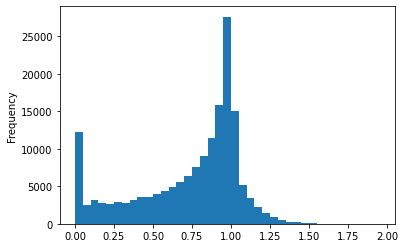

In [21]:
pred.top_score.plot(kind = 'hist', bins = np.arange(0, 2, 0.05))

In [35]:
pred

,0,1,2,3,4,5,6,7,8,9,top_score
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338,0.923182
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491,0.980219
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369,0.361114
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461,0.406496
5,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407,0.944184
...,...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171,0.000233
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697,0.563402
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713,1.078995
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928,0.226957


#### adapting pred to submission format

In [36]:
pred.drop('top_score', axis = 1, inplace = True)

In [37]:
unique_seqs_test = test.seq.unique().shape[0] #177070

In [38]:
pred = pred.reindex(index = range(unique_seqs_test))

In [39]:
top_sellers = list(train[train.event_type.isnull()].item_bought.value_counts().head(10).index.astype(int))

In [40]:
pred[pred[0].isnull()] = top_sellers

In [42]:
pred_6_fn = 'pred_6_implicit.csv'
pred_6_fp = os.path.join(reports_dir, pred_6_fn)
pred.to_csv(pred_6_fp, header = None, index = None)

#### saving implicit ALS model (pkl)
all latent factors included in model

In [50]:
model_6_fn = 'model_6_implicit.pkl'
model_6_fp = os.path.join(models_dir, model_6_fn)
with open(model_6_fp, 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

#### saving item factors (txt)
vector ordered by event_info_id (see event_info_map for a map)

In [121]:
item_factors_6_fn = 'item_factors_6.txt'
item_factors_6_fp = os.path.join(models_dir, item_factors_6_fn)

with open(item_factors_6_fp, 'w') as f:
    for vec in tqdm(model.item_factors):
        f.write('{}\n'.format(' '.join(['{:e}'.format(item) for item in vec])))

100%|██████████| 2101536/2101536 [23:08<00:00, 1513.19it/s]


#### saving event_info_map (pkl)
need to convert event_info (original from meli) into event_info_id (used in implicit)

In [124]:
event_info_map_fn = 'event_info_map.pkl'
event_info_map_fp = os.path.join(models_dir, event_info_map_fn)
event_info_map.to_pickle(event_info_map_fp)

#### testing loading implicit ALS model

In [125]:
model_6_fn = 'model_6_implicit.pkl'
model_6_fp = os.path.join(models_dir, model_6_fn)
with open(model_6_fp, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    model_2 = pickle.load(f)

____